# Predicting ETH prices using NFT data

NFTs allow claiming ownership over digital art or data. Most of these non-fungible tokens are part of the Ethereum blockchain, but also a lot of them are bought using this cryptocurrency. Our goal is to determine whether we can predict the close price of ETH using parameters related to NFT. We were able to find a data set about NFT with different parameters, and merge them with our data frame of ETH Prices, in order to use them as predictors for the Linear Regression model.

### installing dependencies

In [ ]:
!pip install pmdarima

In [ ]:
!pip install quandl

In [ ]:
!pip install Prophet

### Merging the 2 datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
import quandl
import prophet
import json
from utils import *

In [2]:
nft=pd.read_csv('resources/nft.csv')

In [3]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1.020300e+03,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1.240840e+03,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,5.175500e+02,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,4.246300e+02,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1601,2021-11-08,1.008803e+10,10913146,NaN,6541355,14829.0,924.39,7.706698e+07,59264.0,NaN,44435.0
1602,2021-11-09,1.014001e+10,10964025,NaN,6573511,18723.0,924.84,5.197508e+07,50879.0,NaN,32156.0
1603,2021-11-10,1.019902e+10,11008847,NaN,6601205,17128.0,926.44,5.901034e+07,44822.0,NaN,27694.0
1604,2021-11-11,1.023456e+10,11022782,NaN,6609013,6127.0,928.49,3.554317e+07,13935.0,NaN,7808.0


In [4]:
eth=pd.read_csv('resources/coin_Ethereum.csv', parse_dates=True)

In [5]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,6.741880e+05,4.548689e+07
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,5.321700e+05,4.239957e+07
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,4.052830e+05,4.281836e+07
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1.463100e+06,6.456929e+07
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2.150620e+06,7.364501e+07
...,...,...,...,...,...,...,...,...,...,...
2155,2156,Ethereum,ETH,2021-07-02 23:59:59,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
2156,2157,Ethereum,ETH,2021-07-03 23:59:59,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


Firstly, we have combined the two datasets the one contains ETH price data while the other one contains the NFT data.
To do that we had to use the same dates

In [6]:
nft_start_date=nft['Date'][0]
nft_end_date=nft['Date'][nft['Date'].count()-1]

In [7]:
print('nft start',nft_start_date,'nft end',nft_end_date)

nft start 2017-06-22 nft end 2021-11-12


In [8]:
eth_start_date=eth['Date'][0]
eth_end_date=eth['Date'][eth['Date'].count()-1]
print('eth start',eth_start_date,'eth end',eth_end_date)

eth start 2015-08-08 23:59:59 eth end 2021-07-06 23:59:59


In [9]:
eth=eth[eth['Date']>='2017-06-22 23:59:59']
nft=nft[nft['Date']<='2021-07-06']

In [10]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
684,685,Ethereum,ETH,2017-06-22 23:59:59,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10
685,686,Ethereum,ETH,2017-06-23 23:59:59,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10
686,687,Ethereum,ETH,2017-06-24 23:59:59,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10
687,688,Ethereum,ETH,2017-06-25 23:59:59,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10
688,689,Ethereum,ETH,2017-06-26 23:59:59,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10
...,...,...,...,...,...,...,...,...,...,...
2155,2156,Ethereum,ETH,2021-07-02 23:59:59,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
2156,2157,Ethereum,ETH,2021-07-03 23:59:59,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


In [11]:
eth['Date']=eth['Date'].str.extract('(.+)\s') #we had to remove the time part of the date as it was always 23:59:59 and the nft data doesn't have this

C:\Users\tniza\AppData\Local\Temp\ipykernel_10676\3581175994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth['Date']=eth['Date'].str.extract('(.+)\s')


In [12]:
eth.index=np.arange(0,1476)

In [13]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,685,Ethereum,ETH,2017-06-22,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10
1,686,Ethereum,ETH,2017-06-23,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10
2,687,Ethereum,ETH,2017-06-24,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10
3,688,Ethereum,ETH,2017-06-25,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10
4,689,Ethereum,ETH,2017-06-26,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10
...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


In [14]:
i=0
while(eth['Date'].iloc[i]==nft['Date'].iloc[i]):
    i+=1
print(i)
position_of_missing_value=i

932


There was one missing value in the eth dataset so we had to find its position to remove the values for that date in the nft dataset because otherwise dates and data in two datasets would not match

In [15]:
print(eth['Date'].iloc[position_of_missing_value])
print(nft['Date'].iloc[position_of_missing_value])

2020-01-10
2020-01-09


In [16]:
print(eth['Date'].iloc[position_of_missing_value-1])
print(nft['Date'].iloc[position_of_missing_value-1])

2020-01-09
2020-01-09


In [17]:
print(eth['Date'].iloc[position_of_missing_value+1])
print(nft['Date'].iloc[position_of_missing_value+1])

2020-01-11
2020-01-10


In [18]:
nft=nft.drop(position_of_missing_value)

In [19]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1472,2021-07-02,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1473,2021-07-03,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1474,2021-07-04,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1475,2021-07-05,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [20]:
nft.index=np.arange(0,1476)

In [21]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1471,2021-07-02,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2021-07-03,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2021-07-04,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2021-07-05,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [22]:
eth_nft=pd.merge(eth,nft)

In [23]:
#parsing dates and setting index as time
eth_nft['Date'] = pd.to_datetime(eth_nft['Date'])
eth_nft.set_index('Date', inplace=True)
eth_nft

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
Date,,,,,,,,,,,,,,,,,,,
2017-06-22,685,Ethereum,ETH,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-23,686,Ethereum,ETH,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2017-06-24,687,Ethereum,ETH,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
2017-06-25,688,Ethereum,ETH,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
2017-06-26,689,Ethereum,ETH,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,2156,Ethereum,ETH,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
2021-07-03,2157,Ethereum,ETH,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
2021-07-04,2158,Ethereum,ETH,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0


### Analysing 2 merged datasets

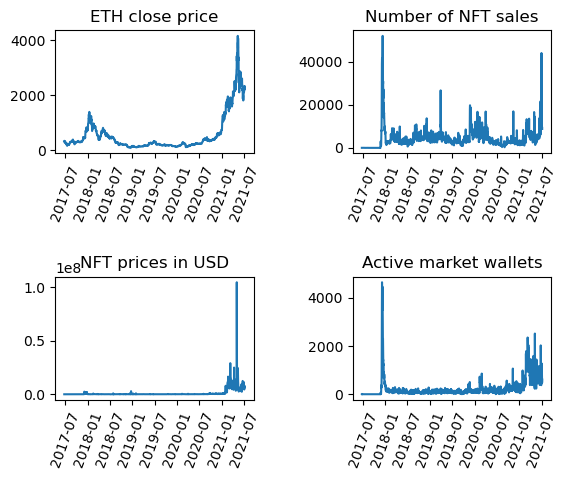

In [24]:
plt.subplot(2, 2, 1)
plt.plot(eth_nft.index, eth_nft['Close'])
plt.xticks(rotation=70)
plt.title('ETH close price')

plt.subplot(2, 2, 2)
plt.plot(eth_nft.index, eth_nft['Number_of_Sales'])
plt.xticks(rotation=70)
plt.title('Number of NFT sales')

plt.subplot(2, 2, 3)
plt.plot(eth_nft.index, eth_nft['Sales_USD'])
plt.xticks(rotation=70)
plt.title('NFT prices in USD')

plt.subplot(2, 2, 4)
plt.plot(eth_nft.index, eth_nft['Active_Market_Wallets'])
plt.xticks(rotation=70)
plt.title('Active market wallets')

plt.subplots_adjust(hspace=1, wspace=0.5)

From these graphs we can see that the first spike in the ETH Close price,Active market wallets, and Number of NFT sales appear at the similar time which means that they might be correlated

ETH close price also rose at the sime time the number of Ative market wallets rose and when there was a spike i NFT prices in USD and Number of NFT sales

In [25]:
parameters=['High','Low','Open','Close','Volume','Marketcap','Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']

In [26]:
parameters.remove('Close')

In [27]:
#resetting data frame without date parsing and default index
eth_nft=pd.merge(eth,nft)
eth_nft=eth_nft.dropna()
eth_nft

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
1,686,Ethereum,ETH,2017-06-23,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,687,Ethereum,ETH,2017-06-24,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,688,Ethereum,ETH,2017-06-25,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,689,Ethereum,ETH,2017-06-26,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
5,690,Ethereum,ETH,2017-06-27,293.088013,227.136993,272.691986,293.088013,1.973870e+09,2.721128e+10,5.296230e+03,100,44.0,0,33.0,52.96,2092.91,33.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [28]:
correlation=eth_nft.corr()
eth_nft.corr().style.background_gradient(cmap='Blues', axis=0)

,SNo,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
SNo,1.000000,0.440720,0.444798,0.441993,0.443847,0.774226,0.483262,0.597830,0.997040,0.947394,0.994254,0.148274,0.050477,0.356418,0.101280,0.286266,0.052421
High,0.440720,1.000000,0.996528,0.998654,0.998159,0.727580,0.996400,0.851590,0.422867,0.653980,0.391004,0.078763,0.681444,0.618406,0.140628,0.483829,0.160749
Low,0.444798,0.996528,1.000000,0.996465,0.998279,0.708881,0.996702,0.849384,0.426631,0.657147,0.394605,0.079250,0.677720,0.621615,0.143187,0.487002,0.164328
Open,0.441993,0.998654,0.996465,1.000000,0.996072,0.722474,0.994430,0.851954,0.424054,0.655374,0.392146,0.077989,0.681155,0.612493,0.140317,0.483865,0.160808
Close,0.443847,0.998159,0.998279,0.996072,1.000000,0.719621,0.998326,0.850208,0.425784,0.656314,0.393802,0.079545,0.679061,0.623991,0.142954,0.487798,0.163768
Volume,0.774226,0.727580,0.708881,0.722474,0.719621,1.000000,0.742507,0.681482,0.763808,0.810372,0.745578,0.100665,0.338029,0.477859,0.061474,0.364504,0.024435
Marketcap,0.483262,0.996400,0.996702,0.994430,0.998326,0.742507,1.000000,0.869025,0.464738,0.688978,0.434295,0.082248,0.680423,0.632351,0.143366,0.489375,0.162528
Sales_USD_cumsum,0.597830,0.851590,0.849384,0.851954,0.850208,0.681482,0.869025,1.000000,0.588723,0.796456,0.573436,0.153463,0.731371,0.558249,0.214336,0.439776,0.221879
Number_of_Sales_cumsum,0.997040,0.422867,0.426631,0.424054,0.425784,0.763808,0.464738,0.588723,1.000000,0.945000,0.996839,0.151509,0.030726,0.342361,0.101425,0.268499,0.050404
Active_Market_Wallets_cumsum,0.947394,0.653980,0.657147,0.655374,0.656314,0.810372,0.688978,0.796456,0.945000,1.000000,0.936584,0.162176,0.253539,0.469658,0.167306,0.377379,0.143863


In this correlation matrix we can see that there is a high correlation between the sum of NFT Sales in USD and the ETH prices (around 85%)

C:\Users\tniza\AppData\Local\Temp\ipykernel_10676\612029065.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(eth_nft.columns, rotation=65, fontsize=15)
C:\Users\tniza\AppData\Local\Temp\ipykernel_10676\612029065.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(eth_nft.columns, rotation=0, fontsize=15)


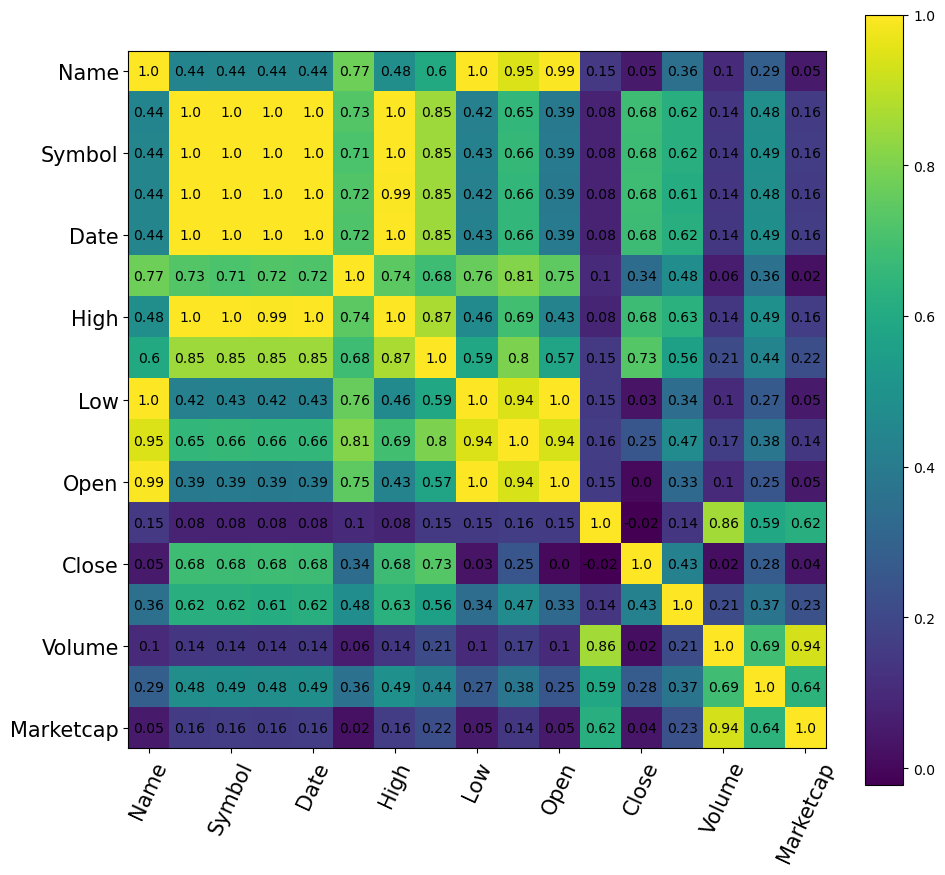

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(correlation, interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

ax.set_xticklabels(eth_nft.columns, rotation=65, fontsize=15)
ax.set_yticklabels(eth_nft.columns, rotation=0, fontsize=15)


for i in range(len(eth_nft.columns)-3):
    for j in range(len(eth_nft.columns)-3):
        text = ax.text(j, i, round(correlation.to_numpy()[i, j], 2),
                       ha="center", va="center", color="black")

plt.show()

In [30]:
train=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.8)]
y_train=train['Close']
test=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.8,eth_nft['Date'].count())]
y_test=test['Close']

In [31]:
#parsing dates and setting index as time
test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date', inplace=True)
test

C:\Users\tniza\AppData\Local\Temp\ipykernel_10676\2255859578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
Date,,,,,,,,,,,,,,,,,,,
2020-09-15,1866,Ethereum,ETH,381.508293,363.606803,377.154029,364.839218,1.614058e+10,4.108764e+10,1.226192e+08,4875270,175767.0,3119480,790.0,25.15,478994.07,2957.0,109.0,2167.0
2020-09-16,1867,Ethereum,ETH,372.767424,356.682746,364.743986,365.812291,1.610761e+10,4.120215e+10,1.228148e+08,4877917,176012.0,3121392,735.0,25.18,195585.79,2647.0,245.0,1912.0
2020-09-17,1868,Ethereum,ETH,393.901600,364.795132,365.865770,389.019220,1.989953e+10,4.382135e+10,1.229943e+08,4879544,176154.0,3122767,252.0,25.21,179491.67,1627.0,142.0,1375.0
2020-09-18,1869,Ethereum,ETH,391.904133,376.964987,389.337495,384.364542,1.410836e+10,4.330219e+10,1.234016e+08,4882740,176594.0,3125048,915.0,25.27,407321.15,3196.0,440.0,2281.0
2020-09-19,1870,Ethereum,ETH,387.076345,378.724069,384.041667,385.544384,1.104951e+10,4.344036e+10,1.237001e+08,4884578,177160.0,3125962,924.0,25.32,298514.39,1838.0,566.0,914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,2156,Ethereum,ETH,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
2021-07-03,2157,Ethereum,ETH,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
2021-07-04,2158,Ethereum,ETH,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0


### Predicting ETH price using NFT data and ETH data

Firstly, we have tried to predict the close price of ETH using all of the parameters in the eth_nft dataset

In [32]:
model=LinearRegression().fit(train[parameters],y_train)

In [33]:
y_pred = model.predict(train[parameters])
rss = sum((train['Close'] - y_pred)**2)

In [34]:
rss

28068.028853582764

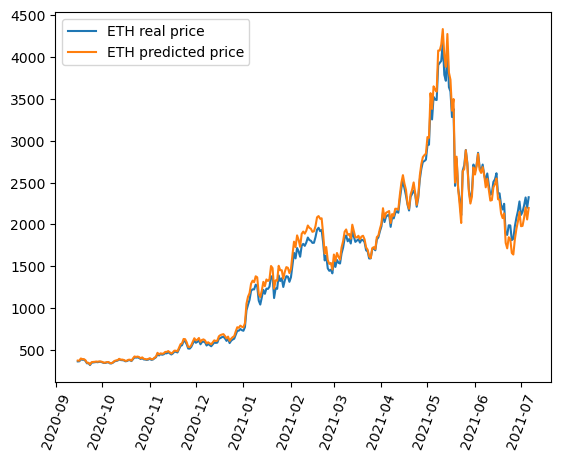

In [35]:
y_pred = model.predict(test[parameters])
rss = sum((y_test - y_pred)**2)
plt.plot(test.index,test['Close'], label='ETH real price')
plt.plot(test.index,y_pred, label='ETH predicted price')
plt.xticks(rotation=70)
plt.legend()

This has resulted in accurate predictions.
However we have used the parameters such as High,Low, and Open that are really close to the Close value becasue ETH prices do not fluctuate much during one day.

In [36]:
rss

1779863.9337920872

In [37]:
train_score=model.score(train[parameters],y_train)

In [38]:
train_score

0.9995192543419086

In [39]:
test_score=model.score(test[parameters],y_test)

In [40]:
test_score

0.9932703610378034

# Finetuning the model: Using Selection Algorithms

This is the same as the previous model we just used Backward and Forward selection to choose the best features

In [41]:
X = eth_nft.drop('Close', axis=1).drop(['Date', 'SNo', 'Name', 'Symbol'], axis=1)
Y = eth_nft['Close']

print('Backward:', validate_best_model(get_all_models(X, Y, n_iteration=len(X.columns), algorithm='backward', features=list(X.columns)), eth_nft, 'Close'))
print('Forward:', validate_best_model(get_all_models(X, Y, n_iteration=len(X.columns)), eth_nft, 'Close'))

Backward: (309290.55013033276, 0.9822968913658974, (LinearRegression(), 309290.55013033276, ['High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum']))
Forward: (309290.55013032537, 0.9822968911228578, (LinearRegression(), 309290.55013032537, ['Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum', 'High', 'Low', 'Open']))


Based on this the best features for predicting the ETH close price are 'High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum'.
As we can see some of these features are from the NFT dataset but most of them are from the eth prices dataset.

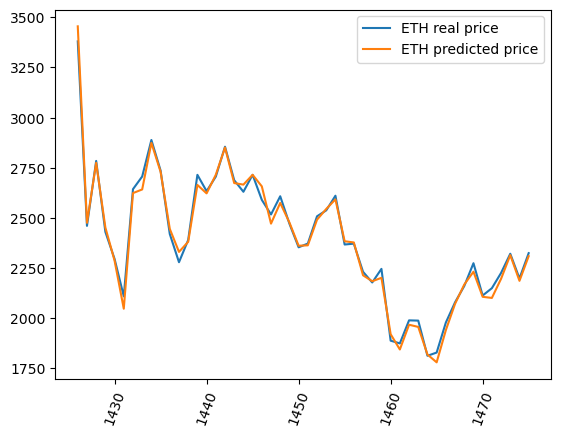

In [42]:
X = eth_nft.drop('Close', axis=1).drop(['SNo', 'Name', 'Symbol'], axis=1)
Y = eth_nft['Close']
Eth_model = LinearRegression().fit(X[['High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum']], Y)
y_predict = Eth_model.predict(X[['High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum']])

eth_nft['Prediction'] = y_predict

sensibility = 50
data = eth_nft.tail(sensibility)
plt.plot(data.index, data['Close'], label='ETH real price')
plt.plot(data.index, data['Prediction'], label='ETH predicted price')
plt.xticks(rotation=70)
plt.legend()
plt.show()

### Predicting the ETH price using only NFT data

Then we tried using just the NFT data to predict the Close price of ETH

In [43]:
train=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.85)]
test=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.85,eth_nft['Date'].count())]
nft_model=LinearRegression().fit(train[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']],train['Close'])

In [44]:
train_score=nft_model.score(train[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']],train['Close'])

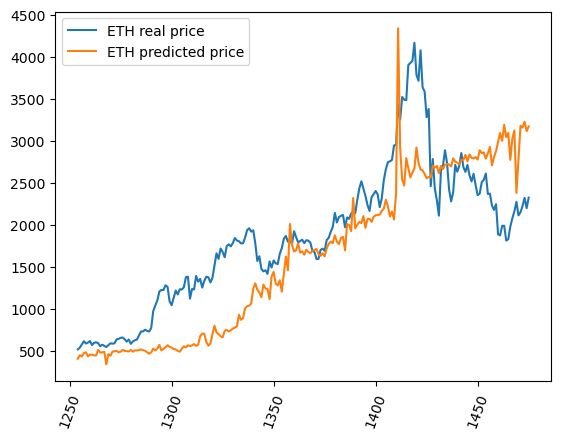

In [45]:
y_pred_nft = nft_model.predict(test[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']])
y_test_nft=test['Close']
rss = sum((y_test_nft - y_pred_nft)**2)
plt.plot(test.index,y_test_nft, label='ETH real price')
plt.plot(test.index,y_pred_nft, label='ETH predicted price')
plt.xticks(rotation=70)
plt.legend()

As we can see from this even though this model is not perfect it still follows the trend of the ETH prices quite wellas shown in the following plot:
![](graph8.png)

In [46]:
test_score=nft_model.score(test[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']],test['Close'])
test_score

0.500382960432016

This model has the accuracy of 50 % which is very good considering it is predicting the price of ETH using the NFT. Even though these two are related, prices of cryptocurrencies are unpredictable so this can be considered as the good score

### Time series prediction auto ARIMA

In [ ]:
def time_series_prediction(df, train_percent):
    train=df.iloc[np.arange(0,df['Date'].count()*train_percent)]
    test=df.iloc[np.arange(df['Date'].count()*train_percent,df['Date'].count())]
    time_series_train=train['Close']
    time_series_test=test['Close']
    model = auto_arima(time_series_train, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(time_series_train)
    forecast = model.predict(n_periods=len(time_series_test))
    return (np.sum((time_series_test-list(forecast.astype(float)))**2),list(forecast.astype(float)))

In [ ]:
forecasts=list(time_series_prediction(eth_nft, i) for i in np.arange(0.5,1,0.05))


Here the function time_series_prediction is called to create a list that contains all prediction prices and and rss for each model. This is calculated for each model with different proportions of train and test data from 50:50 to 95:5 by each 5 percent (50:50,55:45...95:5)

In [ ]:
#minimal=np.argsort(forecasts,key=lambda x:x[0])[0]
minimal=forecasts[0][0]
minimal_index=0
for i in range(len(forecasts)):
    if forecasts[i][0]<minimal:
        minimal=forecasts[i][0]
        minimal_index=i
minimal_percent=minimal_index*0.05+0.5
minimal,minimal_index,minimal_percent

Then the best model is determened by searching for the smallest rss.
In this case that is the 90:10 model

In [ ]:
train=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*minimal_percent)]
test=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.9,eth_nft['Date'].count())]
time_series_train=train['Close']
time_series_test=test['Close']

In [ ]:
plt.plot(train['Date'],time_series_train,label='train')
plt.plot(test['Date'],time_series_test,label='test')
plt.plot(test['Date'],forecasts[minimal_index][1],label='predicted')
plt.legend()

In [ ]:
#score
np.mean(abs(test['Close']-forecasts[minimal_index][1])/((test['Close']+forecasts[minimal_index][1])/2))

### Time series analysis using prophet

Then we tried to predict future ETH prices using Facebook prophet

In [ ]:
prophet_train= eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.9)]['Date']
prophet_train= prophet_train.rename('ds', inplace=True)
prophet_train= pd.DataFrame(prophet_train)
prophet_train['y']=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.9)]['Close']
display(prophet_train)
prophet_test= eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.9,eth_nft['Date'].count())]['Date']
prophet_test= prophet_test.rename('ds', inplace=True)
prophet_test= pd.DataFrame(prophet_test)
prophet_test['y']=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.9,eth_nft['Date'].count())]['Close']
display(prophet_test)

In [ ]:
eth_nft_prophet = prophet.Prophet(changepoint_prior_scale=0.2)
eth_nft_prophet.fit(prophet_train)

In [ ]:
eth_nft_forecast = eth_nft_prophet.make_future_dataframe(periods=test['Date'].count(), freq='D')
# Make predictions
display(eth_nft_forecast)
eth_nft_forecast = eth_nft_prophet.predict(prophet_test)
eth_nft_forecast

In [ ]:
prophet_train['Date'] = pd.to_datetime(prophet_train['Date'])
prophet_train.set_index('Date', inplace=True)
prophet_test['Date'] = pd.to_datetime(prophet_test['Date'])
prophet_test.set_index('Date', inplace=True)

plt.plot(prophet_train['ds'],prophet_train['y'],label='train')
plt.plot(prophet_test['ds'],prophet_test['y'],label='test')
plt.plot(prophet_test['ds'],eth_nft_forecast['yhat'],label='predicted')

In [ ]:
prophet_test.index=np.arange(prophet_test['y'].count())
np.sum((prophet_test['y']-eth_nft_forecast['yhat'])**2)

In [ ]:
#score
np.mean(abs(prophet_test['y']-eth_nft_forecast['yhat'])/((prophet_test['y']+eth_nft_forecast['yhat'])/2))

In [ ]:
prophet_train= eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.6)]['Date']
prophet_train= prophet_train.rename('ds', inplace=True)
prophet_train= pd.DataFrame(prophet_train)
prophet_train['y']=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.6)]['Close']
display(prophet_train)
prophet_test= eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.6,eth_nft['Date'].count())]['Date']
prophet_test= prophet_test.rename('ds', inplace=True)
prophet_test= pd.DataFrame(prophet_test)
prophet_test['y']=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.6,eth_nft['Date'].count())]['Close']
display(prophet_test)

In [ ]:
eth_nft_prophet = prophet.Prophet(changepoint_prior_scale=0.2)
eth_nft_prophet.fit(prophet_train)

In [ ]:
eth_nft_forecast = eth_nft_prophet.make_future_dataframe(periods=test['Date'].count(), freq='D')
# Make predictions
display(eth_nft_forecast)
eth_nft_forecast = eth_nft_prophet.predict(prophet_test)
eth_nft_forecast

In [ ]:
prophet_train['Date'] = pd.to_datetime(prophet_train['Date'])
prophet_train.set_index('Date', inplace=True)
prophet_test['Date'] = pd.to_datetime(prophet_test['Date'])
prophet_test.set_index('Date', inplace=True)

plt.plot(prophet_train['ds'],prophet_train['y'],label='train')
plt.plot(prophet_test['ds'],prophet_test['y'],label='test')
plt.plot(prophet_test['ds'],eth_nft_forecast['yhat'],label='predicted')

In [ ]:
prophet_test.index=np.arange(prophet_test['y'].count())
np.sum((prophet_test['y']-eth_nft_forecast['yhat'])**2)

In [ ]:
#score
np.mean(abs(prophet_test['y']-eth_nft_forecast['yhat'])/((abs(prophet_test['y'])+abs(eth_nft_forecast['yhat']))/2))